# Age and Relationship Status Prediction With Artificial Intelligence: What Your Words Say About You

### Notebook 3: Relationship Status Text Data Analysis and Modeling

by Nadir Sarigul

This notebook is a continuation of Notebook 2 and contains all the code for the models built to predict relationship status from the OKCupid dataset. The data frame used here is the one generated in Notebook 2 and I will follow the same methologies and logics as explained in detail in notebook 2 for implementing predictive models of age groups based on written samples unless otherwise is stated. 

# Data Import and Methodologies

In [2]:
# let's get started importing the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

df = pd.read_csv("data/clean_data.csv.gz")
#df = df.sample(frac=0.2)

import nltk

In [3]:
test_data = df[['status', 'text', 'text_lemmatize', 'clean',
       'nonsense_text']]
test_data.head()

,status,text,text_lemmatize,clean,nonsense_text
0,single,about me:<br />\n<br />\ni would love to think...,would love think kind intellectual either dumb...,would love think kind intellectual either dumb...,would love think kind intellectual either smar...
1,single,i am a chef: this is what that means.<br />\n1...,chef mean workaholic love cook regardless whet...,chef means workaholic love cook regardless whe...,chef love cook regardless whether work love dr...
2,single,"i'm not ashamed of much, but writing public te...",ashamed much writing public text online dating...,ashamed much writing public text online dating...,ashamed much writing public text dating site p...
3,single,i work in a library and go to school. . . read...,work library go school reading thing written o...,work library go school reading things written ...,work library go school reading written old dea...
4,single,hey how's it going? currently vague on the pro...,hey going currently vague profile know come so...,hey going currently vague profile know come so...,hey going currently vague profile know come so...


In [4]:
test_data = test_data.dropna()

In [5]:
test_data.isnull().sum()

status            0
text              0
text_lemmatize    0
clean             0
nonsense_text     0
dtype: int64

# Word Clouds

I used word clouds to visualize the most frequent words used by people in relationship status

In [6]:
#pip install wordcloud

In [7]:
from wordcloud import WordCloud
def plot_wordcloud(corpus, max_words=150, max_font_size=35, figsize=(10,10)):
    corpus = " ".join(corpus)
    wc = WordCloud(collocations=True,background_color='black', max_words=max_words, max_font_size=max_font_size)
    
    wc = wc.generate(corpus) 
    
    fig = plt.figure(num=1, figsize=figsize)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show()

******** single ********


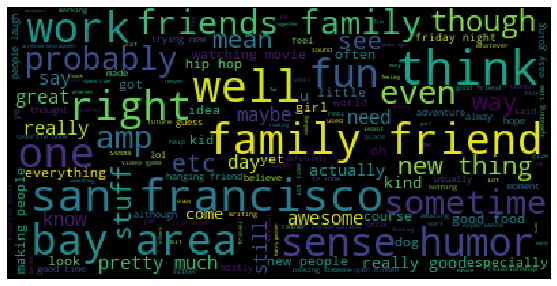

******** relationship ********


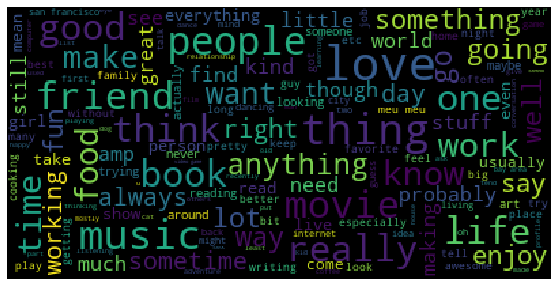

In [8]:
for i in test_data["status"].unique():
    print("******** {} ********".format(i))
    plot_wordcloud(corpus=test_data[test_data["status"]==i]["clean"], max_words=150, max_font_size=35, figsize=(10,5))

Looking at the word clouds of the different relationship status it seems that family-related words are more predominantly used by single people. Moreover, work-related words seem to be less frequently used by people that are in relationships than by single people.

# Frequent Words

In [9]:
from nltk import FreqDist
def frequent(text, number = 30, figsize=(10,7)):
    tokens = nltk.tokenize.word_tokenize(','.join(text))
    freq = FreqDist(tokens)
    #display(freq.most_common(number))
    most_common = pd.DataFrame(freq.most_common(number),
                           columns=['word','count']).sort_values('count',
                                                                 ascending=True)
    #plot
    fig, ax = plt.subplots(figsize=figsize)
    most_common.set_index('word').tail(25).plot(kind='barh',ax=ax)
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()

********* single:  ************


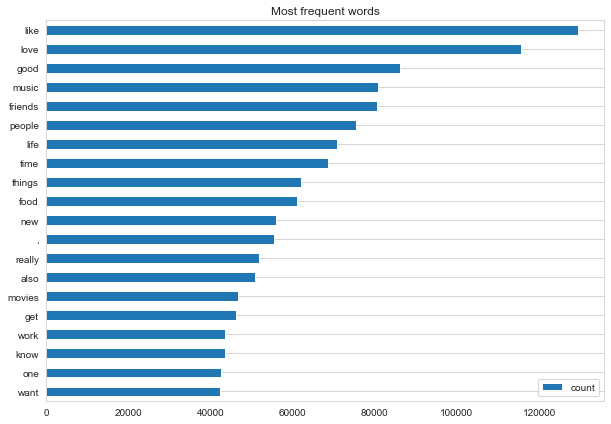

********* relationship:  ************


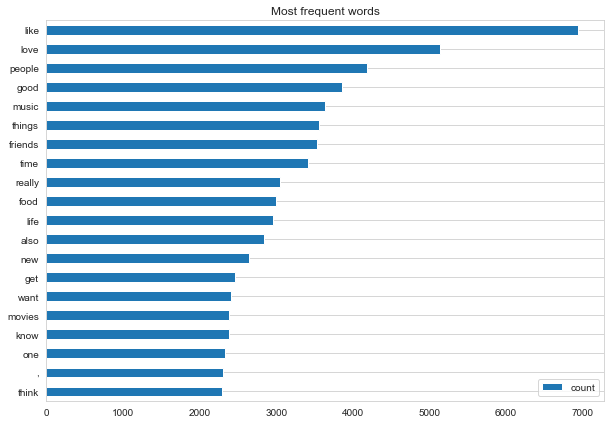

In [10]:
for i in test_data["status"].unique():
    print("********* {}:  ************".format(i))
    frequent(test_data[test_data["status"]==i]["clean"],  20)

# Modeling

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
# preprocesing 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.pipeline import Pipeline
#from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, roc_curve

#from imblearn.over_sampling import RandomOverSampler
#import imblearn.pipeline

import joblib
import re
import string
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

Let's take a look to see how the data looks in each category of the relationship status

In [12]:
test_data["status"].value_counts()

single          55446
relationship     2302
Name: status, dtype: int64

In [13]:
statu_dict = {"single":0, "relationship":1 }
test_data["status"] = test_data["status"].map(statu_dict)
test_data["status"].value_counts()

0    55446
1     2302
Name: status, dtype: int64

Just like we saw with the text data for the age groups, the data for relationship status is also significantly imbalanced with the vast majority of users declaring themselves as single. This is not a surprise considering that this dataset does come from a dating app where the majority of people are either single or declare themselves as single. Much like with the age groups, this imbalance is going to create problems for modeling and introduce bias. I will try to minor this effect using class weights. 

In [14]:
#pip install yellowbrick

In [15]:
from yellowbrick.classifier import ROCAUC

In [16]:
#Function to run model metrics
def model_cl(model,X_train, X_test):   
    print("***********************************************")
    print(f"training score:  {round(model.score(X_train, y_train), 2)}\
        Test score:  {round(model.score(X_test, y_test),2)}")
    print("\n")
    print("********************Cl REPORT****************")

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print(metrics.classification_report(y_test, y_pred))

    print("\n")
    print("***********************************************")

    fig, ax = plt.subplots(ncols=2,figsize=(12,5))
    plot_confusion_matrix(model,X_test, y_test, cmap='Blues',xticks_rotation='vertical',normalize='true',
                                display_labels=["single", "relationship"],
                                ax= ax[0])


    curve  = ROCAUC(model,encoder={0:"single", 
                                   1:"relationship"})#https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html

    curve .fit(X_train, y_train)        # Fit the training data to the visualizer
    curve .score(X_test, y_test)        # Evaluate the model on the test data
    curve .show()                       # Finalize and show the figure 
    #plt.show()

In [17]:
stopwords_list = stopwords.words("english")
stopwords_list += list(string.punctuation)

## Tfidf Vectorizer

Unlike what I first did with the age groups, with this analysis I first started using the lemmatized text and followed up the best model with the other types of cleaned text 

In [18]:
y = test_data["status"]
X = test_data["text_lemmatize"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)


vectorizer =  TfidfVectorizer(stop_words = stopwords_list, encoding='utf-8',decode_error='ignore', max_features = 30000)
X_train_tf = vectorizer.fit_transform(X_train) 
X_test_tf = vectorizer.transform(X_test)

### Dummy Classifier

***********************************************
training score:  0.96        Test score:  0.96


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     16618
           1       0.00      0.00      0.00       707

    accuracy                           0.96     17325
   macro avg       0.48      0.50      0.49     17325
weighted avg       0.92      0.96      0.94     17325



***********************************************


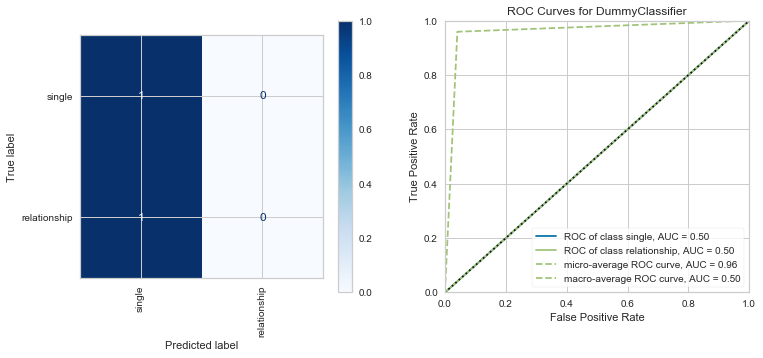

In [19]:
dm= DummyClassifier()
dm.fit(X_train_tf, y_train)
model_cl(dm, X_train_tf, X_test_tf)

The Dummy Classifier recalls correctly 100% of the single group and 0% of people in a relationship. Now that we established the baseline, let's see if we can generate a model that is more accurate predicting the relationship status.

In [20]:
# Balance data using class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

sample_weights = class_weight.compute_sample_weight(weights_dict, y_train)

### Multinomial Naive Bayes

***********************************************
training score:  0.86        Test score:  0.83


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     16618
           1       0.12      0.48      0.19       707

    accuracy                           0.83     17325
   macro avg       0.54      0.66      0.54     17325
weighted avg       0.94      0.83      0.87     17325



***********************************************


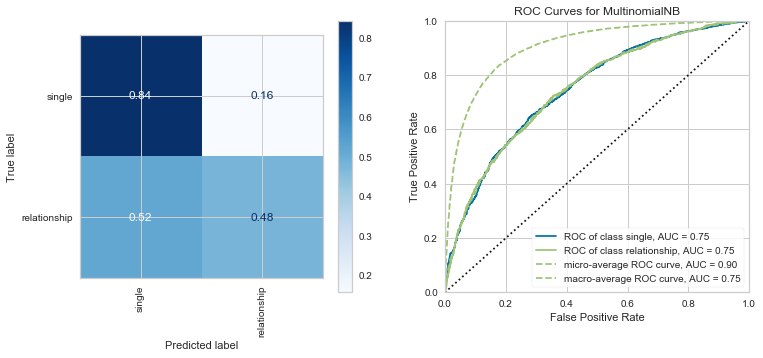

In [21]:
nb_status= MultinomialNB()
nb_status.fit(X_train_tf, y_train, sample_weight=sample_weights)
model_cl(nb_status, X_train_tf, X_test_tf)

In [22]:
#Code for saving the model
pipe_nb_status = Pipeline(steps = [("cv" , TfidfVectorizer(stop_words = stopwords_list, 
                                                           encoding='utf-8',
                                                           decode_error='ignore',
                                                           max_features = 30000)), 
                                   ("nb", MultinomialNB())])
pipe_nb_status.fit(X_train, y_train, 
            **{'nb__sample_weight':sample_weights})

#save model
#joblib.dump(pipe_nb_status, "nb_status_model")

Pipeline(steps=[('cv',
                 TfidfVectorizer(decode_error='ignore', max_features=30000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('nb', MultinomialNB())])

The multinomial naive bayes classifier greatly improved over the Dummy Classifier, as it has a 83% accuracy with the ability to recall correctly 84% of the singles and 48% of people in a relationship. Looking at the ROC curves it looks like the model performes decently, albeit far from perfect. Moreover, the training and test scores are relatively close indicating that the fit of the model is good. So overall this model is somewhat good to predict the different age groups based on their written samples. Let's see if we can improve the ability to recall correctly people in relationships.

### Logistic Regression


***********************************************
training score:  0.91        Test score:  0.87


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     16618
           1       0.14      0.40      0.21       707

    accuracy                           0.87     17325
   macro avg       0.56      0.65      0.57     17325
weighted avg       0.94      0.87      0.90     17325



***********************************************


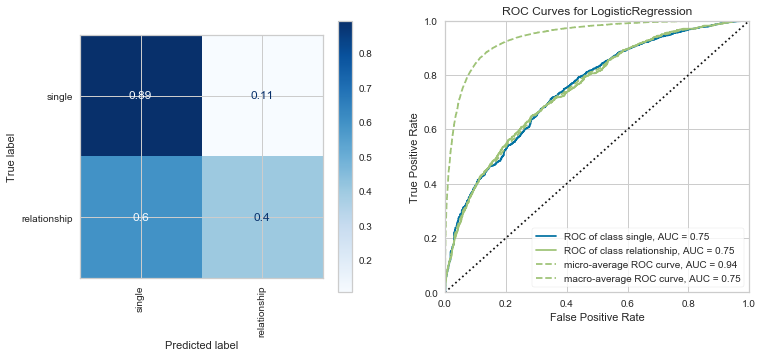

In [23]:
lr= LogisticRegression()
lr.fit(X_train_tf, y_train, sample_weight=sample_weights)
model_cl(lr, X_train_tf, X_test_tf)

The Logistic Regression model while resulting in an overall improvement of accuracy over the naive bayes classifier (from 83% with naive bayes to 87% with logisitic regression) and an increase in the ability to recall single people to 89%. However, it's ability to recall correctly people in relationships is reduced from 48% to 40%. In addition, looking at the model evaluation metrics, it also seems that this is not a better model than the the naive bayes model. 

### Random Forest Classifier

***********************************************
training score:  1.0        Test score:  0.96


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     16618
           1       0.06      0.00      0.00       707

    accuracy                           0.96     17325
   macro avg       0.51      0.50      0.49     17325
weighted avg       0.92      0.96      0.94     17325



***********************************************


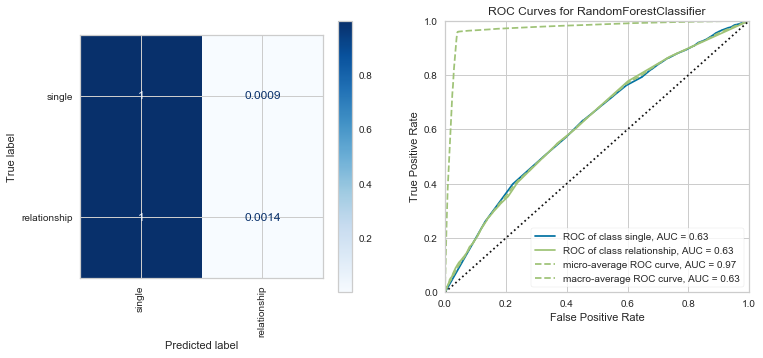

In [24]:
rf1= RandomForestClassifier(class_weight ="balanced")
rf1.fit(X_train_tf, y_train, sample_weight=sample_weights)
model_cl(rf1, X_train_tf, X_test_tf)

The Random Forest Model seems to be the one with the higest degree of accuracy so far (96%). Howeover, this model is completely incapable of differentiating people in relationships from single people as it always recalls people in relationship as single. Moreover, looking at the ROC curves we can see that this model is far from being a good model.  Nevertheless, we can still learn what features are important in the model's determination of people that are single. 

In [25]:
#Determining Features importance 
def plot_importance(tree, X_train, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                      index=vectorizer.get_feature_names()
                             )
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances')
    #return df_importance

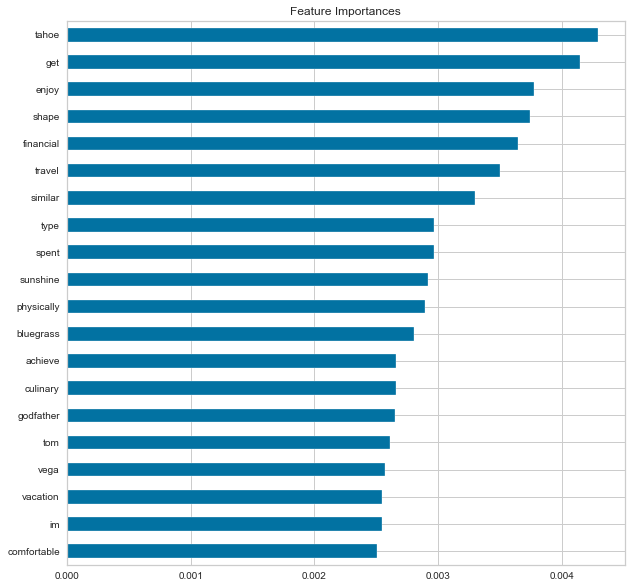

In [26]:
plot_importance(rf1, X_train_tf)

From the models generated so far, the Multinomial Naive Bayes is the one that shows better results. Therefore, I will use that model to try the different text options with the different cleaning levels to see if I can further improve the model's ability to predict people that are in a relationship

In [27]:
#create modeling function
def model(X, model, vector):
    y = test_data["status"]
    X = test_data[X]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)


    vectorizer =  vector(stop_words = stopwords_list, encoding='utf-8', max_features = 30000)
    X_train_tf = vectorizer.fit_transform(X_train) 
    X_test_tf = vectorizer.transform(X_test)
    
    
    mb = model()
    mb.fit(X_train_tf, y_train, sample_weight=sample_weights)
    model_cl(mb, X_train_tf, X_test_tf)
    
#model("clean_text", MultinomialNB,CountVectorizer)

### Multinomial Naive Bayes with Original Text

***********************************************
training score:  0.86        Test score:  0.83


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     16618
           1       0.12      0.48      0.19       707

    accuracy                           0.83     17325
   macro avg       0.55      0.67      0.55     17325
weighted avg       0.94      0.83      0.88     17325



***********************************************


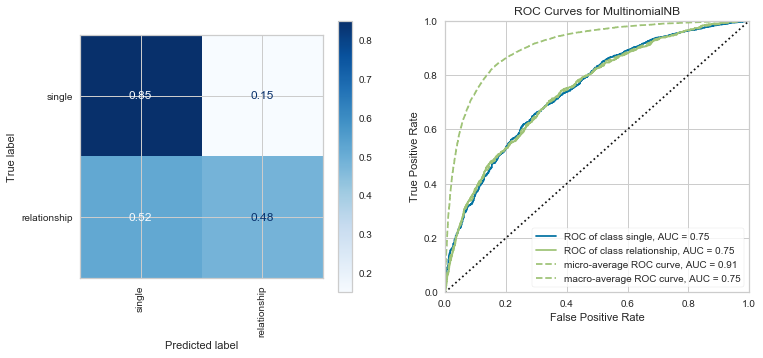

In [28]:
model("clean", MultinomialNB,TfidfVectorizer)

### Multinomial Naive Bayes without Nonsense words

***********************************************
training score:  0.84        Test score:  0.82


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     16618
           1       0.11      0.47      0.17       707

    accuracy                           0.82     17325
   macro avg       0.54      0.65      0.53     17325
weighted avg       0.94      0.82      0.87     17325



***********************************************


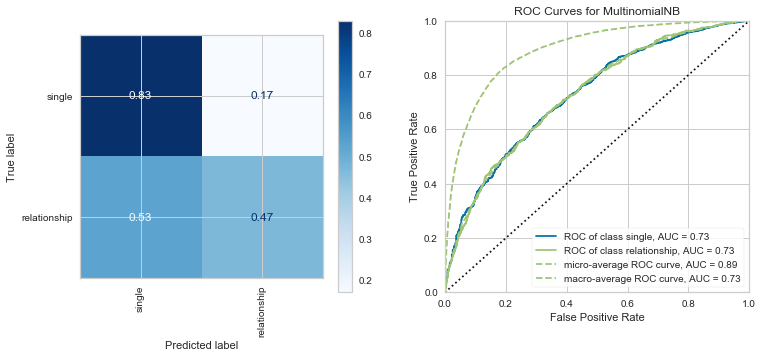

In [29]:
model("nonsense_text", MultinomialNB,TfidfVectorizer)

Changing the input text data did not make the models better.

### N-gram

In [30]:
def ngram_model(X, model, vector):
    y = test_data["status"]
    X = test_data[X]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)


    vectorizer =  vector(stop_words = stopwords_list, encoding='utf-8', max_features = 30000, ngram_range=(2, 2))
    X_train_tf = vectorizer.fit_transform(X_train) 
    X_test_tf = vectorizer.transform(X_test)
    
    
    mb = model()
    mb.fit(X_train_tf, y_train, sample_weight=sample_weights)
    model_cl(mb, X_train_tf, X_test_tf)

#### Multinomial Naive Bayes

***********************************************
training score:  0.89        Test score:  0.84


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     16618
           1       0.11      0.40      0.17       707

    accuracy                           0.84     17325
   macro avg       0.54      0.63      0.54     17325
weighted avg       0.94      0.84      0.88     17325



***********************************************


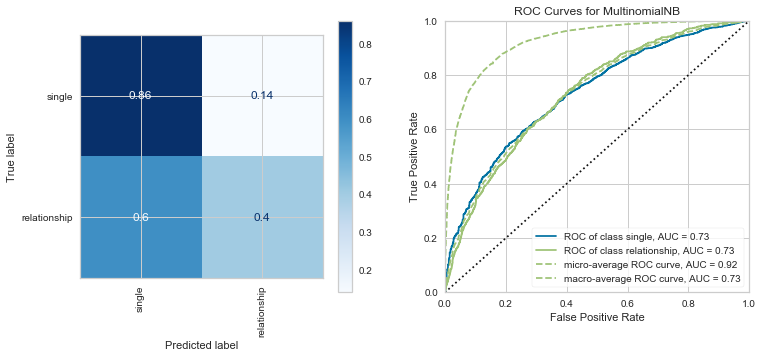

In [31]:
ngram_model("text_lemmatize", MultinomialNB,TfidfVectorizer)

Even though using bigrams increased the accuracy of the model to 84% and the ability to correctly predict single people to 86%, it resulted in a decrease in the ability to predict people in relationships from 48% in the naive bayes classifier using unigram to 40%. Therefore, this is not considered a better model.

#### Logistic Regression

***********************************************
training score:  0.96        Test score:  0.91


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     16618
           1       0.14      0.25      0.18       707

    accuracy                           0.91     17325
   macro avg       0.55      0.59      0.57     17325
weighted avg       0.93      0.91      0.92     17325



***********************************************


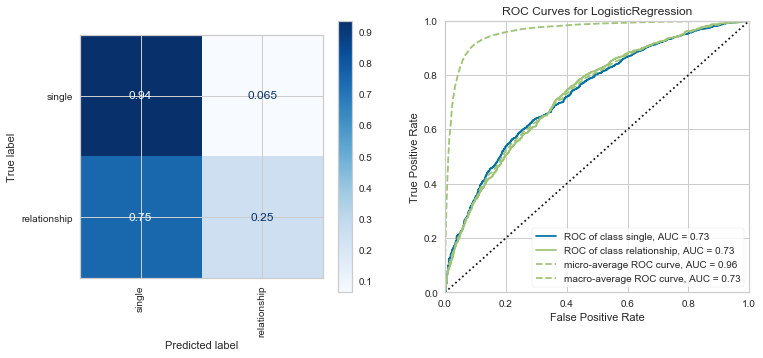

In [32]:
ngram_model("text_lemmatize", LogisticRegression,TfidfVectorizer)

In the case of the logistic regression using bigrams had the same effect as with the naive bayes classifier. It increased both the accuracy and the ability to predict correctly a higher percentage of single people but at the cost of predicting people in relationships more poorly. 


## Count Vectorizer 

### Dummy Classifier

***********************************************
training score:  0.04        Test score:  0.04


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16618
           1       0.04      1.00      0.08       707

    accuracy                           0.04     17325
   macro avg       0.02      0.50      0.04     17325
weighted avg       0.00      0.04      0.00     17325



***********************************************


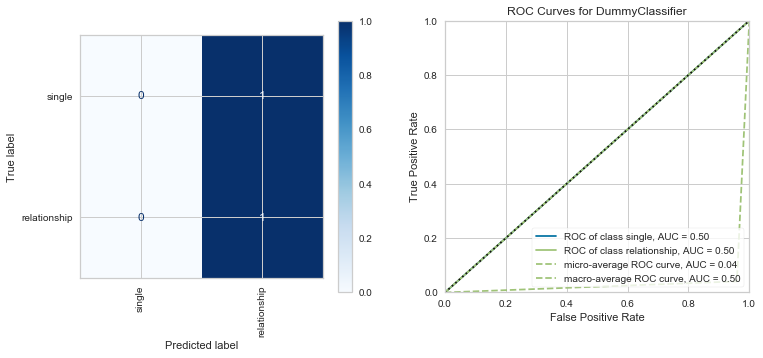

In [33]:
model("text_lemmatize", DummyClassifier, CountVectorizer)

### Random Forest Classifier

***********************************************
training score:  1.0        Test score:  0.96


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     16618
           1       0.00      0.00      0.00       707

    accuracy                           0.96     17325
   macro avg       0.48      0.50      0.49     17325
weighted avg       0.92      0.96      0.94     17325



***********************************************


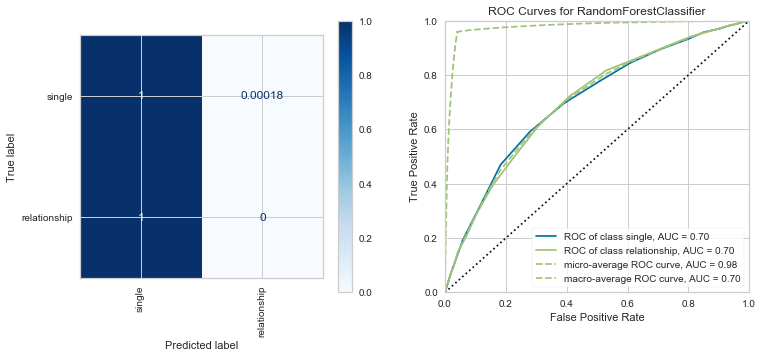

In [34]:
model("text_lemmatize", RandomForestClassifier, CountVectorizer)


### Multinomial Naive Bayes

***********************************************
training score:  0.91        Test score:  0.88


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     16618
           1       0.13      0.35      0.19       707

    accuracy                           0.88     17325
   macro avg       0.55      0.62      0.56     17325
weighted avg       0.94      0.88      0.90     17325



***********************************************


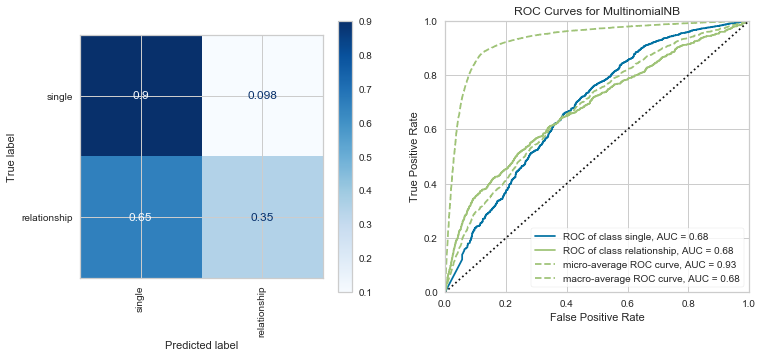

In [35]:
model("text_lemmatize", MultinomialNB,CountVectorizer)

### Logistic Regression

***********************************************
training score:  0.99        Test score:  0.92


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     16618
           1       0.14      0.20      0.16       707

    accuracy                           0.92     17325
   macro avg       0.55      0.57      0.56     17325
weighted avg       0.93      0.92      0.92     17325



***********************************************


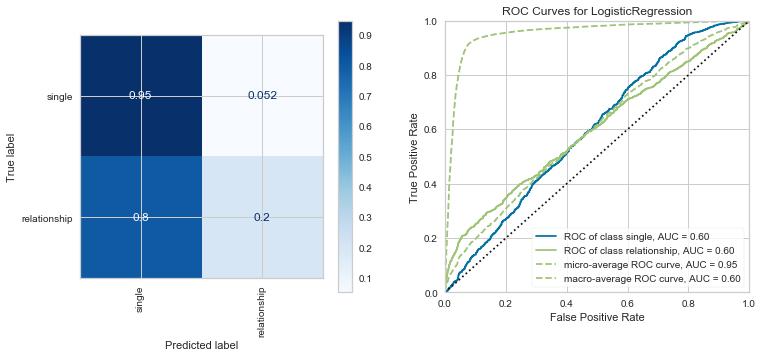

In [36]:
model("text_lemmatize", LogisticRegression,CountVectorizer)

Looking at all three classifiers ran using data inputed with Count Vectorizer it looks like they all are either very similar (Random Forest) or perform worse (Naive Bayes and Logistic Regression) than when ran with data inputed with Tfidt Vectorizer.

# Model Evalutation

My final model to predict relationship from OKCupid data is a Multinomial Naive Bayes Classifier using the lemmatized version of the data but still containing nonsense words. This model can accuratly predict 84% of single people, 51% of people in a relationship and has an overall accuracy of 83%. Looking at the performance metrics, the model seems to perform ok and is not very ofverfitted as the training and test scores are similar (0.85 Training Score and 0.83 test Score).


# Conclusions and Business Recommendations

From this project, with regards to relationship status, I was able to answer the two questions that I put forward when I started the project:

1) Are words used by people of distinct relationship status different?
This analysis shows that it is harder to have a clear distinction between relationship status simply by looking at the words used. It is important to note however that this dataset comes from a dating app and therefore it is very bias towards people that are single or reported themselves as single even if they arent. It will be important to conduct a similar analysis and modeling with a dataset that is not bias towards single people to generate better conclusions about vocabulary choices of single versus people in a relationship. 

3) Is it possible to accuratly predict the reltionship status from the assays one writes on dating profiles?
Similarly to the problem that I encountered with finding specifc word preferences and topics, building a model that accuratly predicts the relationship status based on this dataset proved to be complicated as the data is naturally bias towards people that identify themselves as single. As mentioned above, a future direction of this project will be to perform similar analysis with a dataset that is not related to dating so that the data is more representative of both relationship status and not noise is introduced by people that report being single when in reality they are not.

Similarly to the age group models this model (or a future version of this model that is more accurate) can also be integrated within each advertising company's traditional platforms and implemented in an automatic way such that each individual is categorized onto a specific relationship status group thus helping to tailor what products should be advertised to a specific individual.